# **베이스라인 모델**
* 베이스라인 모델의 제공 목적 
> - 첫째, 제공한 데이터세트를 활용한 머신러닝 Pipeline(분석절차)이 올바르게 동작하는지를 확인
> - 둘째, 제공한 데이터세트를 활용하여 분석 대상 기준 정의 및 제출 결과 파일 생성 방법 등에 참고

* 베이스라인 모델의 구조
> - 데이터 : 크게 train_bookmark라는 시청 이력 데이터와  train_Service라는 고객 상품별 재결제(해지) 이력 데이터
>> - 학습 데이터세트 분할 : train_service 70% & 30%로 분할하여 학습용과 테스트용으로 사용
> - 분석 알고리즘 : XGB 모델 
>> - 기본 설정 모델 제공 
* 베이스라인 모델은 쥬피터 노트북을 통한 Python으로 작성하여 제공
> - 주어진 베이스라인 모델은 예시 이며, 참여들은 자유롭게 분석 방법 및 항목 변경 가능


## **1. 학습 환경 세팅**

> ### 1) 코랩: 구글 드라이브 연동

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 본인이 파일 업로드 한 폴더로 경로 지정

%cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


> ### 2) Import Package 

In [4]:
## 주요 라이브러리 import

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from dateutil.relativedelta import relativedelta
from datetime import *

## **2. 데이터 읽기**

In [5]:
# 서비스 데이터 읽기 : 전체 69,708 rows
# 고객 상품(이용권)별 재결제(해지) 이력 정보
ds_service = "train_service.csv"
df_service = pd.read_csv(ds_service, parse_dates=['registerdate','enddate'], infer_datetime_format=True)

# 데이터에 대한 전반적인 정보를 표시 dataframe을 구성하는 행과 열의 크기, 컬럼명, 컬럼을 구성하는 값의 자료형 등을 출력
df_service.info()
# 데이터 샘플 3개 출력
df_service.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69708 entries, 0 to 69707
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   uno                   69708 non-null  object        
 1   registerdate          69708 non-null  datetime64[ns]
 2   enddate               69708 non-null  datetime64[ns]
 3   productcode           69708 non-null  object        
 4   pgamount              69708 non-null  float64       
 5   chargetypeid          69708 non-null  int64         
 6   concurrentwatchcount  69708 non-null  int64         
 7   promo_100             35729 non-null  object        
 8   coinReceived          12564 non-null  object        
 9   Repurchase            69708 non-null  object        
 10  devicetypeid          69708 non-null  object        
 11  isauth                51727 non-null  object        
 12  gender                58228 non-null  object        
 13  agegroup        

,uno,registerdate,enddate,productcode,pgamount,chargetypeid,concurrentwatchcount,promo_100,coinReceived,Repurchase,devicetypeid,isauth,gender,agegroup
58582,7e63c81609740799060d1bebec2211ba0b5a1a6f0cbad4...,2021-03-12 02:41:39,2021-04-12 02:41:39,pk_2025,7900.0,151,1,NaN,NaN,O,android,NaN,M,40
24817,2e677be4ca113a27bd5827fa037ac037271fbc629f3c01...,2021-03-01 23:05:52,2021-04-01 23:05:52,pk_1487,100.0,134,1,O,NaN,X,pc,Y,F,45
58933,ab79d39a0acfe40c84695ead67bf0bfa34092c03a49c2b...,2021-03-01 20:20:50,2021-04-01 20:20:50,pk_1489,13900.0,131,4,NaN,O,O,pc,NaN,NaN,40


In [6]:
# 시청 이력(train_bookmark) 데이터 읽기 : 전체 412,036 rows
ds_bookmark = "train_bookmark.csv"
df_bookmark = pd.read_csv(ds_bookmark, parse_dates=['dates'], infer_datetime_format=True)

# 데이터에 대한 전반적인 정보를 표시 dataframe을 구성하는 행과 열의 크기, 컬럼명, 컬럼을 구성하는 값의 자료형 등을 출력
df_bookmark.info()
# 데이터 샘플 3개 출력
df_bookmark.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412036 entries, 0 to 412035
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   uno            412036 non-null  object        
 1   dates          412036 non-null  datetime64[ns]
 2   hour           412036 non-null  int64         
 3   channeltype    412036 non-null  object        
 4   programid      411988 non-null  object        
 5   title          385779 non-null  object        
 6   contentid      388043 non-null  object        
 7   contentnumber  363782 non-null  object        
 8   section        385746 non-null  object        
 9   viewtime       412036 non-null  int64         
 10  devicetype     412036 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 34.6+ MB


,uno,dates,hour,channeltype,programid,title,contentid,contentnumber,section,viewtime,devicetype
331800,0730503c3c1d875a6536f7858fd81483315cf05fa6424b...,2021-03-21,18,M,MOVIE,신과함께: 인과 연,MV_CI01_LE0000011223,NaN,M05,10,2
47189,6acfed33109db92d01c5ae21a649ed5d818fef9ac65d00...,2021-03-21,5,V,K02_T2020-1563,오케이 광자매,K02_PS-2021012720-01-000.1,2,1,140,4
274967,b1013cf62e38b40b5b8d746230eba0c7c99d6976ad2649...,2021-03-21,9,V,M_1000786100000100000,무한도전,M_1000786100244100000.1,215,2,1130,1


In [7]:
# service 파일 컬럼별 unique values 확인
for column in df_service.columns.values.tolist():
    print(column)
    print(df_service[column].unique())
    print("")

uno
['b3d6846338d0e98b7e0fcf735c49271ff59df86bfd78f3d75c03d99136f8e0d07bb55627eac3e9a288c20c74cee8641bbdff95108d737b7df108f281d6bbba29'
 '4ec765db76545c1d6dda9f421590bf9d02f584009f8d92100afeef4594ee72306b661c43d19086f82f85f02bbb5716280f52bb7f0fde823a0656a830a0e6e41f'
 '304cacae950e53952afebff0b212f5bfef6a5a0abb4c450879e853055b88063bfc32ee48bea746e952c79f1e1d619db50570991d74d5e19afeb32c5ce1b630dc'
 ...
 '5b14d5322d801571e42101d4d91642f8f7b52a4fcafc01cf02feed746704c66a2f55e2d0f727c4c479a656e718788d0d3e7b95832e6911bf59b44eb8dcb3d71e'
 'd16d0809e827fc3fc676c3850686bef8b311145248d893fc6ccac5c9baa3cb08b9888cb4093f8a66750206fdb6a0da715d9e4ead5cc9dce0b4d4f01621152981'
 '998384efe9466eb3fed96243f6a6831de4deda30bb8deeec0929c15d080a049703b8806fbe8d7786ad726c01b5d62cfb2cc4cf123b8f7f30d0ffa84dd4f0529c']

registerdate
['2021-03-09T16:31:15.000000000' '2021-03-09T14:33:07.000000000'
 '2021-03-09T12:00:01.000000000' ... '2021-03-11T10:04:20.000000000'
 '2021-03-11T21:43:13.000000000' '2021-03-11T19:45

In [8]:
# bookmark 파일 컬럼별 unique values 확인 
for column in df_bookmark.columns.values.tolist():
    print(column)
    print(df_bookmark[column].unique())
    print("")

uno
['b3d6846338d0e98b7e0fcf735c49271ff59df86bfd78f3d75c03d99136f8e0d07bb55627eac3e9a288c20c74cee8641bbdff95108d737b7df108f281d6bbba29'
 '4ec765db76545c1d6dda9f421590bf9d02f584009f8d92100afeef4594ee72306b661c43d19086f82f85f02bbb5716280f52bb7f0fde823a0656a830a0e6e41f'
 '304cacae950e53952afebff0b212f5bfef6a5a0abb4c450879e853055b88063bfc32ee48bea746e952c79f1e1d619db50570991d74d5e19afeb32c5ce1b630dc'
 ...
 '58ea1be6de7c5b1af8b2395386b42f377c209c43f904930b9ede83b16389b0c9751669ebc578e9c0cd8106ea92362006fbadd93f3c2fa7a8dd2212db141e6173'
 'd16d0809e827fc3fc676c3850686bef8b311145248d893fc6ccac5c9baa3cb08b9888cb4093f8a66750206fdb6a0da715d9e4ead5cc9dce0b4d4f01621152981'
 '998384efe9466eb3fed96243f6a6831de4deda30bb8deeec0929c15d080a049703b8806fbe8d7786ad726c01b5d62cfb2cc4cf123b8f7f30d0ffa84dd4f0529c']

dates
['2021-03-21T00:00:00.000000000']

hour
[21  9  8  7  0 18 19 17  4  6  2  5 22 20  1 16 23 14 13 15 12 10 11  3]

channeltype
['V' 'M' 'L' 'E']

programid
['S01_V2000009613' 'M_T60403G' 'S01

## **3. EDA (탐색적 데이터 분석)** 




> ### 1) 결측치 등 데이터 전처리 예시

In [9]:
# 결과 중 결측치 비율을 보고 어느 컬럼을 삭제하고 어느 컬럼을 대체할지를 판단 
df_missing = df_service
np.sum(df_missing.isnull())
missing_number = df_missing.isnull().sum().sort_values(ascending=False)
missing_percentage = missing_number/len(df_missing)
missing_info = pd.concat([missing_number,missing_percentage],  axis=1, keys=['missing number','missing percentage'])
missing_info.head(50)

,missing number,missing percentage
coinReceived,57144,0.819762
promo_100,33979,0.487448
isauth,17981,0.257947
gender,11480,0.164687
agegroup,0,0.000000
devicetypeid,0,0.000000
Repurchase,0,0.000000
concurrentwatchcount,0,0.000000
chargetypeid,0,0.000000
pgamount,0,0.000000


In [10]:
# gender 값 및 분포 확인
print('gender = ', df_service.gender.unique().tolist())
df_service.gender.value_counts()

gender =  ['F', nan, 'M']


F    36591
M    21637
Name: gender, dtype: int64

In [11]:
# gender null 값을 N 으로 변경 후 확인
df_service['gender'] = df_service['gender'].fillna('N')
print('gender = ', sorted(df_service.gender.unique().tolist()))
df_service.gender.value_counts()

gender =  ['F', 'M', 'N']


F    36591
M    21637
N    11480
Name: gender, dtype: int64

In [12]:
# agegroup 값 및 분포 확인
print('agegroup = ', sorted(df_service.agegroup.unique().tolist()))
df_service.agegroup.value_counts()

agegroup =  [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 120, 950]


40     19281
25     12099
30     10435
20      9562
35      6905
45      3739
50      2725
55      1385
15      1227
60       885
0        608
65       414
70       209
75       129
80        70
85        20
90         9
5          2
120        1
95         1
950        1
10         1
Name: agegroup, dtype: int64

In [13]:
# agegroup 950 값을 0 으로 변환
df_service['agegroup'] = df_service['agegroup'].replace(950, 0)
print('agegroup = ', sorted(df_service.agegroup.unique().tolist()))
df_service.agegroup.value_counts()

agegroup =  [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 120]


40     19281
25     12099
30     10435
20      9562
35      6905
45      3739
50      2725
55      1385
15      1227
60       885
0        609
65       414
70       209
75       129
80        70
85        20
90         9
5          2
120        1
95         1
10         1
Name: agegroup, dtype: int64

In [14]:
# pgamount 값 및 분포 확인
print('pgamount = ', sorted(df_service.pgamount.unique().tolist()))
df_service.pgamount.value_counts()

pgamount =  [7.69, 9.89, 9.99, 10.99, 13.19, 13.49, 14.29, 16.49, 17.59, 18.69, 19.79, 20.49, 20.89, 21.99, 24.19, 26.39, 27.49, 29.69, 32.99, 100.0, 2900.0, 3350.0, 3950.0, 4900.0, 5450.0, 5700.0, 5900.0, 6210.0, 6700.0, 6900.0, 6950.0, 7900.0, 8100.0, 8900.0, 9000.0, 9200.0, 9810.0, 9900.0, 10300.0, 10400.0, 10900.0, 11550.0, 11610.0, 11800.0, 12900.0, 13750.0, 13900.0, 14200.0, 16400.0, 16900.0]


100.00      35729
7900.00     12679
9.99         8313
10900.00     5789
13900.00     2350
13.49        2192
16.49         861
3950.00       487
10.99         266
6700.00       262
6950.00       168
5450.00       134
13750.00      119
6900.00        99
14.29          64
5900.00        38
6210.00        19
9.89           17
3350.00        16
13.19          12
4900.00         9
9000.00         9
21.99           8
17.59           7
18.69           5
9900.00         5
16900.00        4
20.49           4
8900.00         4
27.49           3
20.89           3
7.69            3
24.19           3
10300.00        3
19.79           2
12900.00        2
16400.00        2
9200.00         2
5700.00         2
2900.00         2
29.69           2
11800.00        2
8100.00         1
32.99           1
11550.00        1
11610.00        1
10400.00        1
26.39           1
9810.00         1
14200.00        1
Name: pgamount, dtype: int64

In [15]:
# pgamount 금액 중에 달러로 결제된 것 원화로 변경 (pgamount 100원 미만인 건은 Appstore에서 달러 결제 건임)
df_service.loc[(df_service['pgamount'] <  100), 'pgamount'] = df_service['pgamount'] * 1120
print('pgamount = ', sorted(df_service.pgamount.unique().tolist()))
df_service.pgamount.value_counts()

pgamount =  [100.0, 2900.0, 3350.0, 3950.0, 4900.0, 5450.0, 5700.0, 5900.0, 6210.0, 6700.0, 6900.0, 6950.0, 7900.0, 8100.0, 8612.800000000001, 8900.0, 9000.0, 9200.0, 9810.0, 9900.0, 10300.0, 10400.0, 10900.0, 11076.800000000001, 11188.800000000001, 11550.0, 11610.0, 11800.0, 12308.800000000001, 12900.0, 13750.0, 13900.0, 14200.0, 14772.8, 15108.800000000001, 16004.8, 16400.0, 16900.0, 18468.8, 19700.8, 20932.800000000003, 22164.8, 22948.8, 23396.8, 24628.8, 27092.800000000003, 29556.8, 30788.8, 33252.8, 36948.8]


100.0      35729
7900.0     12679
11188.8     8313
10900.0     5789
13900.0     2350
15108.8     2192
18468.8      861
3950.0       487
12308.8      266
6700.0       262
6950.0       168
5450.0       134
13750.0      119
6900.0        99
16004.8       64
5900.0        38
6210.0        19
11076.8       17
3350.0        16
14772.8       12
9000.0         9
4900.0         9
24628.8        8
19700.8        7
9900.0         5
20932.8        5
8900.0         4
16900.0        4
22948.8        4
30788.8        3
27092.8        3
10300.0        3
23396.8        3
8612.8         3
12900.0        2
22164.8        2
16400.0        2
9200.0         2
5700.0         2
2900.0         2
33252.8        2
11800.0        2
29556.8        1
8100.0         1
11550.0        1
11610.0        1
36948.8        1
10400.0        1
9810.0         1
14200.0        1
Name: pgamount, dtype: int64

In [16]:
# 기타 컬럼들의 결측치 처리
df_service = df_service.fillna('X')

> ### 2) 자율 : Feature 생성 및 파생변수 생성은 자율로 추가: 예시 모델 제공  

In [18]:
# 변수 생성(Feature Extraction) (예시)
#   (1) 고객별 서비스 가입 이력 수
#   (2) 고객별 서비스 가입 이력 상품 수
#   (3) 고객별 시청 건수 (1시간 단위)
#   (4) 고객별 시청 총 시간
#   (5) 고객별 시청 평균 시간
#   (6) 고객별 시청 채널 수
#   (7) 고객별 시청 프로그램 수
#   (8) 고객별 시청 디바이스 수

# (1) 고객별 서비스 가입 이력 수
df_feature_1 = df_service.groupby(by='uno', as_index=False).registerdate.count()
df_feature_1.rename(columns={'registerdate':'REG_CNT'}, inplace=True)
print('REG_CNT = ', sorted(df_feature_1.REG_CNT.unique().tolist()))
#print('REG_CNT = ', df_feature_1.REG_CNT.value_counts())

# (2) 고객별 서비스 가입 이력 상품 수
df_feature_2 = df_service[['uno','productcode']]
df_feature_2 = df_feature_2.drop_duplicates() # 고객별 동일 상품 제거
df_feature_2 = df_feature_2.groupby(by='uno', as_index=False).productcode.count()
df_feature_2.rename(columns={'productcode':'PRD_CNT'}, inplace=True)
print('PRD_CNT = ', sorted(df_feature_2.PRD_CNT.unique().tolist()))
#print('PRD_CNT = ', df_feature_2.PRD_CNT.value_counts())

# (3) 고객별 시청 건수 (1시간 단위)
df_feature_3 = df_bookmark.groupby(by='uno', as_index=False).dates.count()
df_feature_3.rename(columns={'dates':'BM_CNT'}, inplace=True)

print('BM_CNT = ', sorted(df_feature_3.BM_CNT.unique().tolist()))
#print('BM_CNT = ', df_feature_3.BM_CNT.value_counts())

# (4) 고객별 시청 총 시간
df_feature_4 = df_bookmark.groupby(by='uno', as_index=False).viewtime.sum()
df_feature_4.rename(columns={'viewtime':'VT_TOT'}, inplace=True)
print('VT_TOT = ', sorted(df_feature_4.VT_TOT.unique().tolist()))
#print('VT_TOT = ', df_feature_4.VT_TOT.value_counts())

# (5) 고객별 시청 평균 시간
df_feature_5 = df_bookmark.groupby(by='uno', as_index=False).viewtime.mean()
df_feature_5.rename(columns={'viewtime':'VT_AVG'}, inplace=True)
print('VT_AVG = ', sorted(df_feature_5.VT_AVG.unique().tolist()))
#print('VT_AVG = ', df_feature_5.VT_AVG.value_counts())

# (6) 고객별 시청 채널 수
df_feature_6 = df_bookmark[['uno','channeltype']]
df_feature_6 = df_feature_6.drop_duplicates() # 고객별 동일 채널 제거
df_feature_6 = df_feature_6.groupby(by='uno', as_index=False).channeltype.count()
df_feature_6.rename(columns={'channeltype':'CH_CNT'}, inplace=True)
print('CH_CNT = ', sorted(df_feature_6.CH_CNT.unique().tolist()))
#print('CH_CNT = ', df_feature_6.CH_CNT.value_counts())

# (7) 고객별 시청 프로그램 수
df_feature_7 = df_bookmark[['uno','programid']]
df_feature_7 = df_feature_7.drop_duplicates() # 고객별 동일 프로그램 제거
df_feature_7 = df_feature_7.groupby(by='uno', as_index=False).programid.count()
df_feature_7.rename(columns={'programid':'PRG_CNT'}, inplace=True)
print('PRG_CNT = ', sorted(df_feature_7.PRG_CNT.unique().tolist()))
#print('PRG_CNT = ', df_feature_7.PRG_CNT.value_counts())

# (8) 고객별 시청 디바이스 수
df_feature_8 = df_bookmark[['uno','devicetype']]
df_feature_8 = df_feature_8.drop_duplicates() # 고객별 동일 프로그램 제거
df_feature_8 = df_feature_8.groupby(by='uno', as_index=False).devicetype.count()
df_feature_8.rename(columns={'devicetype':'DEV_CNT'}, inplace=True)
print('DEV_CNT = ', sorted(df_feature_8.DEV_CNT.unique().tolist()))
#print('DEV_CNT = ', df_feature_8.DEV_CNT.value_counts())

REG_CNT =  [1, 2, 3, 5, 7]
PRD_CNT =  [1, 2, 3, 4]
BM_CNT =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 112, 113, 117, 119, 120, 121, 124, 125, 126, 130, 131, 132, 134, 137, 138, 140, 148, 151, 154, 165, 166, 168, 172, 176, 204, 208, 221, 359]
VT_TOT =  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 7

In [19]:
print('df_feature_1 = ', df_feature_1.shape[0])
print('df_feature_2 = ', df_feature_2.shape[0])
print('df_feature_3 = ', df_feature_3.shape[0])
print('df_feature_4 = ', df_feature_4.shape[0])
print('df_feature_5 = ', df_feature_5.shape[0])
print('df_feature_6 = ', df_feature_6.shape[0])
print('df_feature_7 = ', df_feature_7.shape[0])
print('df_feature_8 = ', df_feature_8.shape[0])

df_feature_1 =  69145
df_feature_2 =  69145
df_feature_3 =  43608
df_feature_4 =  43608
df_feature_5 =  43608
df_feature_6 =  43608
df_feature_7 =  43608
df_feature_8 =  43608


In [20]:
# 해지 예측 대상 서비스에 생성한 변수 연결
df_svc_target = pd.merge(df_svc_target, df_feature_1, on='uno', how='left')
df_svc_target = pd.merge(df_svc_target, df_feature_2, on='uno', how='left')
df_svc_target = pd.merge(df_svc_target, df_feature_3, on='uno', how='left')
df_svc_target = pd.merge(df_svc_target, df_feature_4, on='uno', how='left')
df_svc_target = pd.merge(df_svc_target, df_feature_5, on='uno', how='left')
df_svc_target = pd.merge(df_svc_target, df_feature_6, on='uno', how='left')
df_svc_target = pd.merge(df_svc_target, df_feature_7, on='uno', how='left')
df_svc_target = pd.merge(df_svc_target, df_feature_8, on='uno', how='left')

In [21]:
# 추가 생성 컬럼들의 결측치 처리
df_svc_target = df_svc_target.fillna(0)
df_svc_target = df_svc_target.astype({'BM_CNT':'int', 'VT_TOT':'int', 'CH_CNT':'int', 'PRG_CNT':'int', 'DEV_CNT':'int'})

In [22]:
# 최종 분석 대상 데이터
df_T = df_svc_target.copy()
df_T.info()
df_T.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69145 entries, 0 to 69144
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   uno                   69145 non-null  object        
 1   registerdate          69145 non-null  datetime64[ns]
 2   enddate               69145 non-null  datetime64[ns]
 3   productcode           69145 non-null  object        
 4   pgamount              69145 non-null  float64       
 5   chargetypeid          69145 non-null  int64         
 6   concurrentwatchcount  69145 non-null  int64         
 7   promo_100             69145 non-null  object        
 8   coinReceived          69145 non-null  object        
 9   Repurchase            69145 non-null  object        
 10  devicetypeid          69145 non-null  object        
 11  isauth                69145 non-null  object        
 12  gender                69145 non-null  object        
 13  agegroup        

,uno,registerdate,enddate,productcode,pgamount,chargetypeid,concurrentwatchcount,promo_100,coinReceived,Repurchase,devicetypeid,isauth,gender,agegroup,REG_CNT,PRD_CNT,BM_CNT,VT_TOT,VT_AVG,CH_CNT,PRG_CNT,DEV_CNT
51000,360ded9f8cb4f87656e78aea375a861f21578c6ed5d094...,2021-03-04 11:27:57,2021-04-04 11:27:57,pk_1489,100.0,134,4,O,X,O,pc,Y,M,30,1,1,20,26250,1312.500000,1,4,1
50090,95ba3391c230cf029e27bf09a7d120875e9c77bf3920b6...,2021-03-11 22:41:53,2021-04-11 22:41:53,pk_2025,100.0,151,1,O,X,X,android,Y,M,25,1,1,9,6070,674.444444,1,1,1
8737,4564a1bb3d664a325924760b16a51ab6b2c5f22da27d51...,2021-03-12 05:29:32,2021-04-12 05:29:32,pk_1488,10900.0,132,2,X,X,O,pc,Y,M,45,1,1,65,80090,1232.153846,1,4,1
39672,e8a4a41c7b1f98dcffaa4581ce43e2574f91bdf289efda...,2021-03-12 19:39:13,2021-04-12 19:39:13,pk_1488,10900.0,131,2,X,X,O,android,Y,M,35,1,1,6,2330,388.333333,1,1,1
32816,79f5d952eb5da9d64ce289c5a4a55730e0b76f9549d0ed...,2021-03-06 09:14:10,2021-04-06 09:14:10,pk_1487,100.0,180,1,O,X,O,mobile,Y,F,40,1,1,25,34960,1398.400000,1,6,2


> ### 4) 상관관계/분포도 확인 

In [23]:
# Encoding categorical variables to numeric ones

# Label 컬럼은 직접 변환
print('Repurchase = ', df_T.Repurchase.unique().tolist())
print(df_T.Repurchase.value_counts())
df_T['CHURN'] = np.where(df_T.Repurchase == 'X', 1, 0)   # 재결제('O') -> Churn Negative(0), 미결제('X') -> Churn Positive(1)
print('CHURN = ', df_T.CHURN.unique().tolist())
print(df_T.CHURN.value_counts())

# 이외 컬럼들은 일괄 자동 변환
col_lst = df_T.columns.values.tolist()
col_lst.remove('uno')
col_lst.remove('productcode')
for c in col_lst:
    if df_T[c].dtype == 'object':
        print(c)
        lbl = LabelEncoder()
        lbl.fit(list(df_T[c].values))
        df_T[c] = lbl.transform(df_T[c].values)
df_T.sample(5)

Repurchase =  ['X', 'O']
O    47352
X    21793
Name: Repurchase, dtype: int64
CHURN =  [1, 0]
0    47352
1    21793
Name: CHURN, dtype: int64
promo_100
coinReceived
Repurchase
devicetypeid
isauth
gender


,uno,registerdate,enddate,productcode,pgamount,chargetypeid,concurrentwatchcount,promo_100,coinReceived,Repurchase,devicetypeid,isauth,gender,agegroup,REG_CNT,PRD_CNT,BM_CNT,VT_TOT,VT_AVG,CH_CNT,PRG_CNT,DEV_CNT,CHURN
48312,0bb9d12ec9edc8cd492869e8e0f43908a6fa583fefbd04...,2021-03-09 22:55:21,2021-04-09 22:55:21,pk_2025,100.0,151,1,0,1,1,0,1,1,45,1,1,0,0,0.000000,0,0,0,1
2117,a718607f994750c9953579123be4680c206707d1245914...,2021-03-03 16:27:29,2021-04-03 16:27:29,pk_1487,100.0,180,1,0,1,0,4,1,1,20,1,1,0,0,0.000000,0,0,0,0
61205,ef6affc6b470fe52f3ee99644191c5e9ac09037c415af9...,2021-03-06 15:33:42,2021-04-06 15:33:42,pk_1487,7900.0,134,1,1,1,0,0,1,1,35,1,1,10,9680,968.000000,1,5,1,0
66200,035efd71b9b996f421d74a2b312cea71d910cf3adcd7c9...,2021-03-10 00:44:45,2021-04-10 00:44:45,pk_1508,11188.8,140,1,1,1,0,1,0,0,40,1,1,3,4250,1416.666667,1,1,1,0
43629,3bd960961d5d22aefe879186c24cda8f308f39c7ac07d1...,2021-03-07 03:54:34,2021-04-07 03:54:34,pk_1487,100.0,134,1,0,1,1,4,1,1,25,1,1,2,4120,2060.000000,1,1,1,1


In [24]:
# 기술 통계 현황 확인
df_T.describe()

,pgamount,chargetypeid,concurrentwatchcount,promo_100,coinReceived,Repurchase,devicetypeid,isauth,gender,agegroup,REG_CNT,PRD_CNT,BM_CNT,VT_TOT,VT_AVG,CH_CNT,PRG_CNT,DEV_CNT,CHURN
count,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000,69145.000000
mean,5081.745474,146.837255,1.691778,0.484966,0.819900,0.315178,2.251327,0.743394,0.638123,33.425193,1.008142,1.007896,5.959014,6528.766216,730.745662,0.751435,1.537002,0.848926,0.315178
std,5489.790373,18.873183,1.088627,0.499778,0.384273,0.464590,2.805912,0.436763,0.747176,10.944240,0.096089,0.090451,10.193466,10782.807718,732.290109,0.669008,2.240925,0.830144,0.464590
min,100.000000,121.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,134.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,25.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100.000000,140.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,35.000000,1.000000,1.000000,2.000000,2490.000000,673.181818,1.000000,1.000000,1.000000,0.000000
75%,10900.000000,151.000000,2.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,40.000000,1.000000,1.000000,8.000000,8450.000000,1290.000000,1.000000,2.000000,1.000000,1.000000
max,36948.800000,190.000000,4.000000,1.000000,1.000000,1.000000,10.000000,1.000000,2.000000,120.000000,7.000000,4.000000,359.000000,175000.000000,5446.666667,4.000000,89.000000,7.000000,1.000000


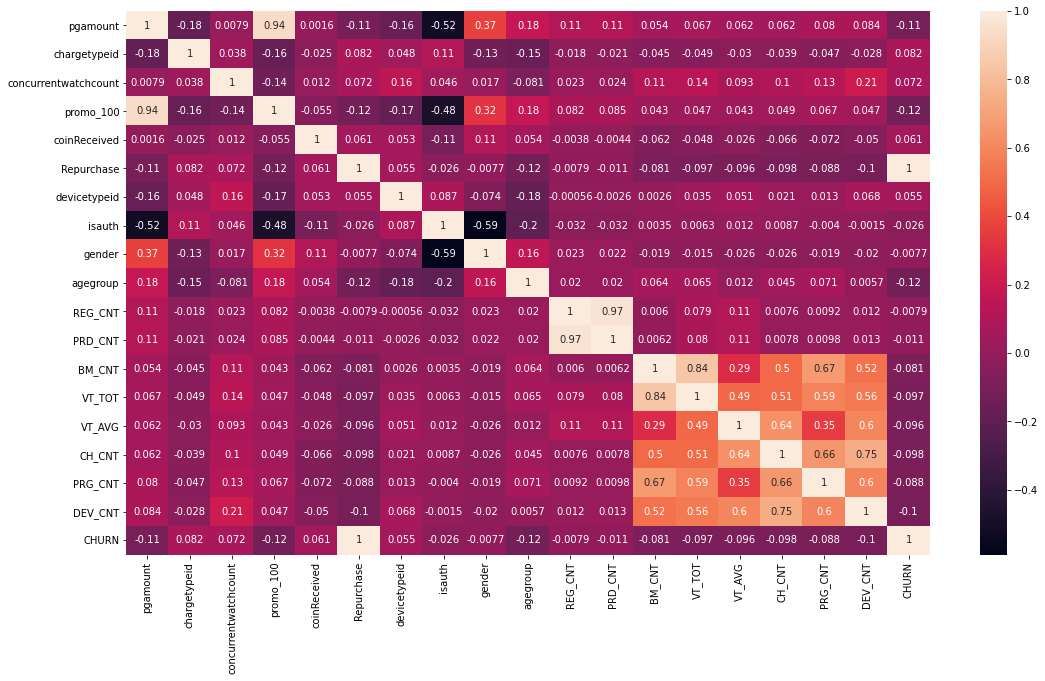

In [25]:
# Basic correlation plot to understand which features are correlated
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(18,10))
sns.heatmap(df_T.corr(), annot=True)   

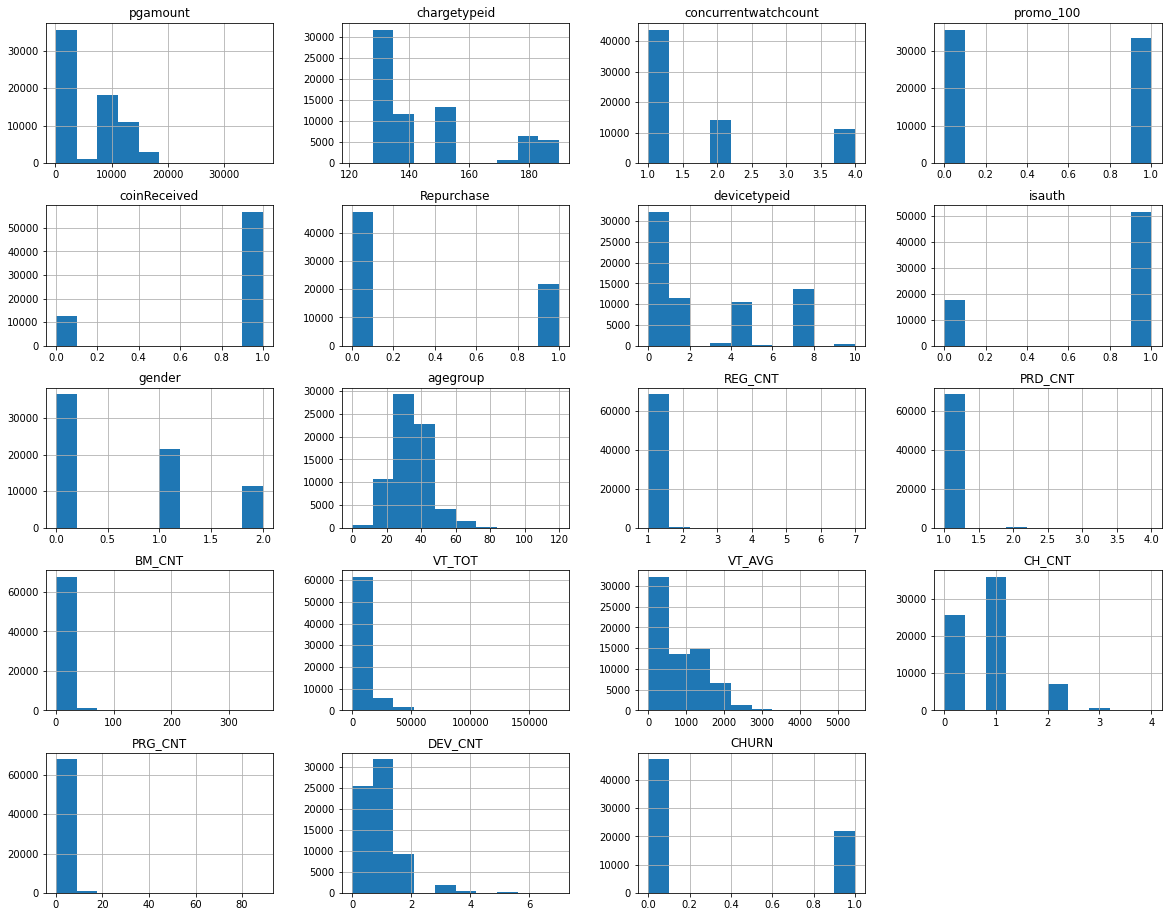

In [26]:
# This also helps in finding number of counts in each column
df_T.hist(figsize=(20,16))
plt.show()  # showing the charts of different columns

## **4. 모델 훈련**

> ### 1) Train/Test 데이터 설정 

In [ ]:
# 베이스라인 모델에서는 특정 월정액만 기준으로 진행 
# 실제 경연에서는 전체 월정액 대상
#df_T['productcode'].value_counts()
#df_T = df_T.loc[(df_T['productcode'] == 55)] # productcode = pk_1489

In [27]:
# Train/Test 데이터 분리 
X = df_T.drop(["uno","registerdate","enddate","productcode","Repurchase","CHURN"], axis=1)
#X = df_T.drop(["registerdate","enddate","productcode","Repurchase","CHURN"], axis=1)
y = df_T["CHURN"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 111)

In [28]:
print('Traing X     = ', len(X_train), ', Training Y   = ', len(y_train))
print('Validation X = ', len(X_test),  ', Validation Y = ', len(y_test))

Traing X     =  55316 , Training Y   =  55316
Validation X =  13829 , Validation Y =  13829


> ### 2) 모델 생성 

In [29]:
###
###        모델 학습 시 검증(평가) 지표 설정
###           ㅇ 본 경연의 평가 지표
###              - 1 순위 : F1
###              - 2 순위 : Accuracy
###

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

#got the best parameters above
xgb = XGBClassifier(learning_rate = 0.3, max_depth = 3, n_estimators = 100,
                    eval_metric = 'aucpr', 
                    use_label_encoder=False, 
                    objective = 'binary:logistic', random_state = 1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='aucpr',
              gamma=0, learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

> ### 3) 학습 모델 예측력 검증

In [30]:
y_pred = xgb.predict(X_test)

# printing the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.95      0.82      9545
           1       0.65      0.20      0.31      4284

    accuracy                           0.72     13829
   macro avg       0.69      0.58      0.57     13829
weighted avg       0.70      0.72      0.66     13829



> ### 4) 학습 모델 평가(Validation) 

In [31]:
# confusion matrics to find precision and recall
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[9082,  463],
       [3414,  870]])

In [32]:
###       예측 주제 관련 평가 지표 사용
###           ㅇ 예측 주제
###              - 이탈 즉, 2개월차 제결제하지 않음
###           ㅇ 이탈 여부 코딩
###              - 이탈 : 1 (= 재결제하지 않음)
###              - 유지 : 0 (= 재결제함)
###           ㅇ 평가 지표
###              - 이탈(1)에 대한 평가 지표로 Leaderboard 순위 부여

import sklearn.metrics as metrics

print('accuracy', metrics.accuracy_score(y_test,y_pred) )
print('precision', metrics.precision_score(y_test,y_pred) )
print('recall', metrics.recall_score(y_test,y_pred) )
print('f1', metrics.f1_score(y_test,y_pred) )
print(metrics.classification_report(y_test,y_pred))
print(metrics.confusion_matrix(y_test,y_pred))

accuracy 0.7196471183744305
precision 0.6526631657914479
recall 0.2030812324929972
f1 0.30977390065871463
              precision    recall  f1-score   support

           0       0.73      0.95      0.82      9545
           1       0.65      0.20      0.31      4284

    accuracy                           0.72     13829
   macro avg       0.69      0.58      0.57     13829
weighted avg       0.70      0.72      0.66     13829

[[9082  463]
 [3414  870]]


## **5. 예측 결과 파일 제출**

In [33]:
# Predict Input 파일 읽기 - 서비스 파일
ds_P_service = "predict_service.csv"
df_P_service = pd.read_csv(ds_P_service, parse_dates=['registerdate','enddate'], infer_datetime_format=True)

df_P_service.info()
#df_P_service.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   uno                   19001 non-null  object        
 1   registerdate          19001 non-null  datetime64[ns]
 2   enddate               19001 non-null  datetime64[ns]
 3   productcode           19001 non-null  object        
 4   pgamount              19001 non-null  float64       
 5   chargetypeid          19001 non-null  int64         
 6   concurrentwatchcount  19001 non-null  int64         
 7   promo_100             10019 non-null  object        
 8   coinReceived          3220 non-null   object        
 9   Repurchase            248 non-null    object        
 10  devicetypeid          19001 non-null  object        
 11  isauth                14219 non-null  object        
 12  gender                16056 non-null  object        
 13  agegroup        

In [34]:
# Predict Input 파일 읽기 - 북마크 파일
ds_P_bookmark = "predict_bookmark.csv"
df_P_bookmark = pd.read_csv(ds_P_bookmark, parse_dates=['dates'], infer_datetime_format=True)

df_P_bookmark.info()
#df_pbook.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120986 entries, 0 to 120985
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   uno            120986 non-null  object        
 1   dates          120986 non-null  datetime64[ns]
 2   hour           120986 non-null  int64         
 3   channeltype    120986 non-null  object        
 4   programid      120975 non-null  object        
 5   title          114533 non-null  object        
 6   contentid      115026 non-null  object        
 7   contentnumber  108145 non-null  object        
 8   section        114524 non-null  object        
 9   viewtime       120986 non-null  int64         
 10  devicetype     120986 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 10.2+ MB


**학습 데이터 전처리 기준 동일 적용**

In [35]:
# gender null 값을 N 으로 변경 후 확인
df_P_service['gender'] = df_P_service['gender'].fillna('N')

# agegroup 950 값을 0 으로 변환
df_P_service['agegroup'] = df_P_service['agegroup'].replace(950, 0)

# pgamount 금액 중에 달러로 결제된 것 원화로 변경 (pgamount 100원 미만인 건은 Appstore에서 달러 결제 건임)
df_P_service.loc[(df_P_service['pgamount'] <  100), 'pgamount'] = df_P_service['pgamount'] * 1120

# 기타 컬럼들의 결측치 처리
df_P_service = df_P_service.fillna('X')

# 해지 예측 대상 서비스 추출
# 즉, 예측시점(가입일+3주)에 해지하지 않은 서비스 추출
df_P_svc_target = df_P_service[df_P_service.enddate >= df_P_service.registerdate + pd.DateOffset(weeks=3)]

# 변수 생성(Feature Extraction) (예시)
# (1) 고객별 서비스 가입 이력 수
df_P_feature_1 = df_P_service.groupby(by='uno', as_index=False).registerdate.count()
df_P_feature_1.rename(columns={'registerdate':'REG_CNT'}, inplace=True)

# (2) 고객별 서비스 가입 이력 상품 수
df_P_feature_2 = df_P_service[['uno','productcode']]
df_P_feature_2 = df_P_feature_2.drop_duplicates() # 고객별 동일 상품 제거
df_P_feature_2 = df_P_feature_2.groupby(by='uno', as_index=False).productcode.count()
df_P_feature_2.rename(columns={'productcode':'PRD_CNT'}, inplace=True)

# (3) 고객별 시청 건수 (1시간 단위)
df_P_feature_3 = df_P_bookmark.groupby(by='uno', as_index=False).dates.count()
df_P_feature_3.rename(columns={'dates':'BM_CNT'}, inplace=True)

# (4) 고객별 시청 총 시간
df_P_feature_4 = df_P_bookmark.groupby(by='uno', as_index=False).viewtime.sum()
df_P_feature_4.rename(columns={'viewtime':'VT_TOT'}, inplace=True)

# (5) 고객별 시청 평균 시간
df_P_feature_5 = df_P_bookmark.groupby(by='uno', as_index=False).viewtime.mean()
df_P_feature_5.rename(columns={'viewtime':'VT_AVG'}, inplace=True)

# (6) 고객별 시청 채널 수
df_P_feature_6 = df_P_bookmark[['uno','channeltype']]
df_P_feature_6 = df_P_feature_6.drop_duplicates() # 고객별 동일 채널 제거
df_P_feature_6 = df_P_feature_6.groupby(by='uno', as_index=False).channeltype.count()
df_P_feature_6.rename(columns={'channeltype':'CH_CNT'}, inplace=True)

# (7) 고객별 시청 프로그램 수
df_P_feature_7 = df_P_bookmark[['uno','programid']]
df_P_feature_7 = df_P_feature_7.drop_duplicates() # 고객별 동일 프로그램 제거
df_P_feature_7 = df_P_feature_7.groupby(by='uno', as_index=False).programid.count()
df_P_feature_7.rename(columns={'programid':'PRG_CNT'}, inplace=True)

# (8) 고객별 시청 디바이스 수
df_P_feature_8 = df_P_bookmark[['uno','devicetype']]
df_P_feature_8 = df_P_feature_8.drop_duplicates() # 고객별 동일 프로그램 제거
df_P_feature_8 = df_P_feature_8.groupby(by='uno', as_index=False).devicetype.count()
df_P_feature_8.rename(columns={'devicetype':'DEV_CNT'}, inplace=True)

# 해지 예측 대상 서비스에 생성한 변수 연결
df_P_svc_target = pd.merge(df_P_svc_target, df_P_feature_1, on='uno', how='left')
df_P_svc_target = pd.merge(df_P_svc_target, df_P_feature_2, on='uno', how='left')
df_P_svc_target = pd.merge(df_P_svc_target, df_P_feature_3, on='uno', how='left')
df_P_svc_target = pd.merge(df_P_svc_target, df_P_feature_4, on='uno', how='left')
df_P_svc_target = pd.merge(df_P_svc_target, df_P_feature_5, on='uno', how='left')
df_P_svc_target = pd.merge(df_P_svc_target, df_P_feature_6, on='uno', how='left')
df_P_svc_target = pd.merge(df_P_svc_target, df_P_feature_7, on='uno', how='left')
df_P_svc_target = pd.merge(df_P_svc_target, df_P_feature_8, on='uno', how='left')

# 추가 생성 컬럼들의 결측치 처리
df_svc_target = df_svc_target.fillna(0)
df_svc_target = df_svc_target.astype({'BM_CNT':'int', 'VT_TOT':'int', 'CH_CNT':'int', 'PRG_CNT':'int', 'DEV_CNT':'int'})

df_P_svc_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18753 entries, 0 to 18752
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   uno                   18753 non-null  object        
 1   registerdate          18753 non-null  datetime64[ns]
 2   enddate               18753 non-null  datetime64[ns]
 3   productcode           18753 non-null  object        
 4   pgamount              18753 non-null  float64       
 5   chargetypeid          18753 non-null  int64         
 6   concurrentwatchcount  18753 non-null  int64         
 7   promo_100             18753 non-null  object        
 8   coinReceived          18753 non-null  object        
 9   Repurchase            18753 non-null  object        
 10  devicetypeid          18753 non-null  object        
 11  isauth                18753 non-null  object        
 12  gender                18753 non-null  object        
 13  agegroup        

In [36]:
# 최종 분석 대상 데이터
df_P = df_P_svc_target.copy()

# Encoding categorical variables to numeric ones
col_lst = df_P.columns.values.tolist()
col_lst.remove('uno')
col_lst.remove('productcode')
for c in col_lst:
    if df_P[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(df_P[c].values))
        df_P[c] = lbl.transform(df_P[c].values)

df_P.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18753 entries, 0 to 18752
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   uno                   18753 non-null  object        
 1   registerdate          18753 non-null  datetime64[ns]
 2   enddate               18753 non-null  datetime64[ns]
 3   productcode           18753 non-null  object        
 4   pgamount              18753 non-null  float64       
 5   chargetypeid          18753 non-null  int64         
 6   concurrentwatchcount  18753 non-null  int64         
 7   promo_100             18753 non-null  int64         
 8   coinReceived          18753 non-null  int64         
 9   Repurchase            18753 non-null  int64         
 10  devicetypeid          18753 non-null  int64         
 11  isauth                18753 non-null  int64         
 12  gender                18753 non-null  int64         
 13  agegroup        

In [37]:
# 예측 모델 입력을 위한 최종 데이터
X_predict = df_P.drop(["uno","registerdate","enddate","productcode","Repurchase"], axis=1)

**예측 모델에 의핸 해지 예측**

In [38]:
# 예측 모델에 최종 데이터 입력
y_pred = xgb.predict(X_predict)

In [39]:
# 데이터 건수 확인
print('예측 대상 건수 = ', len(X_predict), ', 예측 결과 건수 = ', len(y_pred))

예측 대상 건수 =  18753 , 예측 결과 건수 =  18753


**예측 결과 답안지 제출**

In [40]:
# 결과 제출 답안지 불러오기
ds_sheet = "CDS_submission.csv"
df_sheet = pd.read_csv(ds_sheet)
df_sheet.drop('CHURN', axis=1, inplace=True)
df_sheet.info()

# 답안지에 답안 표기
df_result = df_P.loc[:,('uno','registerdate','productcode')]
df_result['KEY']   = df_result['uno'] + '|' + df_result['registerdate'].dt.strftime('%y-%m-%d %I:%M:%S') + '|' + df_result['productcode']   # 판다스 strftime()
df_result['CHURN'] = pd.DataFrame(y_pred)
df_result = df_result.loc[:,('KEY','CHURN')]
df_answer_sheet = pd.merge(df_sheet, df_result, on='KEY', how='left')
df_answer_sheet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18753 entries, 0 to 18752
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   KEY     18753 non-null  object
dtypes: object(1)
memory usage: 146.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18753 entries, 0 to 18752
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   KEY     18753 non-null  object
 1   CHURN   18753 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 439.5+ KB


In [41]:
# 답안지 제출 파일 생성하기
ds_answer_sheet = "CDS_submission_팀명_차수.csv"
df_answer_sheet.to_csv(ds_answer_sheet, index=False, encoding='utf8')

# End